In [1]:
import numpy as np
import pandas as pd
from pprint import pprint
import itertools
import operator
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.metrics import concordance_index_censored

# input data

# 層別化

$$ 
\begin{align}
    ER+ : \ H_c(t)  &= exp\big(0.7424402 - \frac{7.527762}{\sqrt{t}} - 1.812513 \times \frac{log(t)}{\sqrt{t}}\big) \\
    ER- : \ H_c(t)  &= exp\big(-1.156036 + \frac{0.4707332}{t^2} - \frac{3.51355}{t}\big)
\end{align}
$$

In [106]:
class Patient:
    """Patient class

    Patientごとの生存時間解析を行うクラス
    
    Attributes:
        # 患者の情報
        age (int): 患者の年齢
        detection (int): 発見契機 symptoms detected = 0, screen detected = 1, unknown = 2
        size (float): Tumour size (mm)
        grade (int) : Tumour grade 1, 2 or 3 only
        nodes (int) : がんが転移したリンパ節の数
        er (int) : ER+ = 1, ER- = 0
        her2 (int) : her2+ = 1, her2- = 0 missing = 2
        ki67 (int) : ki67+ = 1, ki67- = 0 missing = 2
        event (int) : event発生の有無 0, 1
        duration (int) : event発生時間
        
        # Tretment Options
        chemo_gen (int) : Chemo generation 0, 2 or 3 only 
        horm (int) :  Hormone therapy Yes = 1, no = 0
        traz (int) : Trastuzumab therapy Yes = 1, no = 0
        bis (int) : Bisphosphonate therapy Yes = 1, no = 0
        treatment_options (str) : 患者が行っている治療法の結合 -> "c0:h1:t0:b1"
        
        # other
        max_time (int) : 打ち切りまでの時間（年）
        time 
        coef_ : 回帰係数
    
    """
    def __init__(self,patient_data):
        # 患者の情報
        self.patient_data = patient_data
        self.pID =  patient_data["pID"].values[0]
        self.age =  patient_data["age"].values[0]
        
        self.detection = patient_data['detection'].values[0]
        self.detection =  0.204 if self.detection == 2 else self.detection
        
        self.size = patient_data['tumour_size'].values[0]
        
        self.grade = patient_data['tumour_grade'].values[0]
        self.grade = 2.13 if self.grade == 9 else self.grade
        
        self.nodes = patient_data['nodes'].values[0]
        self.er = patient_data['er'].values[0]
        self.her2 = patient_data['her2'].values[0]
        self.ki67 = patient_data['ki67'].values[0]
        
        # Tretment Options
        self.chemo_gen = patient_data['chemo_generation'].values[0]
        self.horm = patient_data['hormonetherapy'].values[0]
        self.traz = patient_data['trastuzumab'].values[0]
        self.bis = patient_data['bisphosphonates'].values[0]
        self.event = patient_data['event'].values[0]
        self.duration = patient_data['duration'].values[0]
        
        self.treatment_options = f"h{int(self.horm)}:c{int(self.chemo_gen)}:t{int(self.traz)}:b{int(self.bis)}"
        #self.treatment_options_forR = self.__treatment_options_forR()
        
        # other
        self.max_time = 15
        self.time = np.array(range(1,self.max_time+1))
        self.__set_model()
        self.__other_causes_model()
        self.__cancer_causes_model()

    def treatment_options_forR(self):
        options = f"h{int(self.horm)}:c{int(self.chemo_gen)}:t{int(self.traz)}:b{int(self.bis)}"
        treatments = [treat[0] for treat in options.split(":") if int(treat[1]) > 0]
        if len(treatments) == 0:
            return 's'
        else:
            treatment_options = ''
            for treatment in treatments:
                treatment_options += treatment
            return treatment_options
        
    def get_patient_data(self):
        """患者の入力情報を辞書式で返すメソッド

        Returns:
            dict: 患者の情報
        """
        columns = list(self.patient_data.columns)
        data = self.patient_data.values[0]
        param_dict = {col:datum for col, datum in zip(columns, data)}
        self.params = param_dict
        return param_dict
    
    def print_patient_data(self):
        pprint(self.get_patient_data())
    
    def __set_model(self):
        """患者の情報からモデルの重みを決定するメソッド

        Returns:
            np.array:重みの情報
        """
        if self.er == 1:
            # data_point
            age_mfp_1 = (self.age/10)**-2-0.0287449295 
            age_mfp_2 = (self.age/10)**-2*np.log(self.age/10)-0.0510121013 
            size_mfp = np.log(self.size/100)+1.545233938 
            nodes_mfp = np.log((self.nodes+1)/10)+1.387566896 
            grade_mfp =  self.grade
            detection_mfp = 0.204 if self.detection == 9 else self.detection
            her2_mfp = 1
            ki67_mfp = 1
            
            # weight
            age_beta_1 = 34.53642 
            age_beta_2 = -34.20342  
            size_beta = 0.7530729 
            nodes_beta = 0.7060723 
            grade_beta = 0.746655 
            detection_beta = -0.22763366
            her2_beta = 0.2413 if self.her2 == 1 else -0.0762 if self.her2 == 0 else 0
            ki67_beta = 0.14904 if self.ki67 == 1 else -0.11333 if self.ki67 == 0 else 0
            
            
        else:
            # data_point
            age_mfp_1 = self.age-56.3254902 
            age_mfp_2 = 0  
            size_mfp = (self.size/100)**0.5-0.5090456276  
            nodes_mfp = np.log((self.nodes+1)/10)+1.086916249   
            grade_mfp = 1 if self.grade == 2 or self.grade == 3 else 0
            detection_mfp = 0
            her2_mfp = 1
            ki67_mfp = 1
            
            # weight
            age_beta_1 = 0.0089827
            age_beta_2 = 0
            size_beta = 2.093446
            nodes_beta = 0.6260541
            grade_beta = 1.129091 
            detection_beta = 0
            her2_beta = 0.2413 if self.her2 == 1 else -0.0762 if self.her2 == 0 else 0
            ki67_beta = 0
            
        x_1 = np.array([age_mfp_1,age_mfp_2,detection_mfp,size_mfp,grade_mfp,nodes_mfp,her2_mfp,ki67_mfp])
        w_1 = np.array([age_beta_1,age_beta_2,detection_beta,size_beta,grade_beta,nodes_beta,her2_beta,ki67_beta])
        pi = np.dot(w_1,x_1)
 
        c_mfp = 1 
        h_mfp = 1 
        # h10_mfp = 1
        t_mfp = 1
        b_mfp = 1

        c_beta = 0 if self.chemo_gen == 0 else -0.248 if self.chemo_gen == 2 else -0.446
        h_beta = -0.3857 if self.horm == 1 and self.er == 1 else 0
        # h10_beta = [horm for i in range(10)] + [horm-0.26 for i in range(len(time)-10)]
        t_beta = -0.3567 if self.her2 == 1 and self.traz == 1 else 0
        b_beta = -0.198 if self.bis == 1 else 0

        x_2 = np.array([c_mfp,h_mfp,t_mfp,b_mfp])
        w_2 = np.array([c_beta,h_beta,t_beta,b_beta])
        rx = np.dot(w_2,x_2)
        
        self.coef_ = {"w_1": w_1, "x_1": x_1, "w_2": w_2, "x_2": x_2}
        self.base = "ER+" if self.er == 1 else "ER-"
        self.pi = pi
        self.rx = rx
        self.polynomial = pi + rx
    
    def __other_causes_model(self):
        """癌が原因でないモデル
        
        """
        # Other mortality prognostic index (mi)
        mi = 0.0698252*((self.age/10)**2-34.23391957)
        
        # Generate cumulative baseline other mortality
        base_m_cum_oth = np.exp(-6.052919 + (1.079863*np.log(self.time)) + (0.3255321*self.time**0.5))
        
        # Generate cumulative survival non-breast mortality
        s_cum_oth = np.exp(-np.exp(mi)*base_m_cum_oth)
        # Convert cumulative mortality rate into cumulative risk
        m_cum_oth = 1- s_cum_oth
        
        # Annual other mortality rate
        m_oth = np.array([i for i in m_cum_oth])

        for i in range(1,self.max_time):
            m_oth[i] = m_cum_oth[i] - m_cum_oth[i-1]
            
        self._s_cum_oth = s_cum_oth
        self._m_cum_oth = m_cum_oth
        
    def __cancer_causes_model(self):
        """癌が原因のモデル
        """
        # Generate cumulative baseline breast mortality
        if self.base == "ER+":
            base_m_cum_br = np.exp(0.7424402 - 7.527762/self.time**0.5 - 1.812513*np.log(self.time)/self.time**0.5)
        else:
            base_m_cum_br = np.exp(-1.156036 + 0.4707332/self.time**2 - 3.51355/self.time)
            
        # Annual cancer mortality rate
        base_m_br = np.array([i for i in base_m_cum_br])

        for i in range(1,self.max_time):
            base_m_br[i] = base_m_cum_br[i] - base_m_cum_br[i-1]

        # Generate the annual breast cancer specific mortality rate
        m_br = base_m_br * np.exp(self.polynomial)
        
        #累積和
        m_cum_br = np.array(list(itertools.accumulate(m_br)))
        s_cum_br = np.exp(- m_cum_br)
        m_cum_br =  1- s_cum_br
        
        self._s_cum_br = s_cum_br
        self._m_cum_br = m_cum_br
    
    def predict(self):
        """risk_scoreを返すメソッド
        Returns
        -------
        risk_score : float
            Predicted risk scores.
        
        """
        return self.polynomial
        
    def predict_cumulative_hazard_function(self):
        """Predict cumulative hazard function.
        Returns
        -------
        cum_hazard : ndarray ()

        """
        
        m_cum_all = 1 - self._s_cum_oth*self._s_cum_br
        self._m_cum_all = m_cum_all*100
        return self._m_cum_all
        
    def predict_survival_function(self):
        """Predict cumulative survival function.
        Returns
        -------
        survival : ndarray ()

        """
        m_cum_all = 1 - self._s_cum_oth*self._s_cum_br
        s_cum_all = 100-100*m_cum_all
        
        self._s_cum_all = s_cum_all
        return self._s_cum_all
    
class Patient_Score:
    def __init__(self,input_data):
        self.input_data = input_data
        self.patients = [Patient(patient_data=input_data.query(f" pID == {pID}")) for pID in input_data['pID'].unique()]
        self.data = [(patient.pID, patient.predict(),patient.event, patient.duration) for patient in self.patients]
        self.score_df = pd.DataFrame(self.data,columns=['pID', 'risk_score', 'event','duration']).reset_index(drop=True)
        self.score_df['event'] = self.score_df['event'].apply(lambda x: True if x == 1 else False)
        
    def score(self):
        score = concordance_index_censored(
            event_indicator = self.score_df['event'].values,
            event_time = self.score_df['duration'].values,
            estimate = self.score_df['risk_score'].values,
        )[0]
        
        return score


In [204]:
input_data = pd.read_csv("./input_data3.csv")
patients = [Patient(patient_data=input_data.query(f" pID == {pID}")) for pID in input_data['pID'].unique()]
patient = iter(patients)
input_data.head()

,pID,age,detection,tumour_size,tumour_grade,nodes,er,her2,ki67,chemo_generation,hormonetherapy,trastuzumab,bisphosphonates,event,duration
0,1,26,0,2,2,9,1,1,0,0,0,0,0,0,15
1,2,55,1,5,2,1,1,0,1,3,1,0,0,0,15
2,3,44,0,14,2,5,1,1,1,2,1,1,1,0,15
3,4,75,1,11,2,1,0,1,0,2,0,1,0,0,15
4,5,62,0,7,3,0,0,0,0,2,0,0,0,0,15


In [224]:
pat = next(patient)


20

# 検証


In [107]:
input_data = pd.read_csv("./input_data_verlification.csv")
patients = [Patient(patient_data=input_data.query(f" pID == {pID}")) for pID in input_data['pID'].unique()]
data = [(patient.pID, patient.predict(),patient.event, patient.duration) for patient in patients]
input_data.head()

,pID,age,detection,tumour_size,tumour_grade,nodes,er,her2,ki67,chemo_generation,hormonetherapy,trastuzumab,bisphosphonates,event,duration,options
0,1,26,0,2,2,9,1,1,0,0,0,0,0,0,15,s
1,2,55,1,5,2,1,1,0,1,3,1,0,0,0,15,h
2,3,44,0,14,2,5,1,1,1,2,1,1,1,0,15,htb
3,4,75,1,11,2,1,0,1,0,2,0,1,0,0,15,t
4,5,62,0,7,3,0,0,0,0,2,0,0,0,0,15,s


In [135]:
ids = []
test5 = []
test10 = []
test15 = []
for id in input_data['pID'].unique():
    patient = patients[id-1]
    df = pd.DataFrame(patient.predict_survival_function(),columns=[patient.treatment_options_forR()]).iloc[[4,9,14],:]
    ids.append(int(id))
    test5.append(df.values[0][0])
    test10.append(df.values[1][0])
    test15.append(df.values[2][0])

In [149]:
compare_python = pd.DataFrame(np.array([ids,test5,test10,test15]).T,columns=['id','python_5','python_10','python_15'])
compare_python['id'] = compare_python['id'].astype('int')
compare_r = pd.read_csv('./verlification_r.csv').loc[:,['ids','r_5','r_10','r_15']]

In [158]:
compare = pd.concat([compare_r,compare_python],axis='columns').drop(columns='id')
compare['diff5'] = round(compare['r_5'] -  compare['python_5'], 5)
compare['diff10'] = round(compare['r_10'] -  compare['python_10'], 5)
compare['diff15'] = round(compare['r_15'] -  compare['python_15'], 5)
compare

,ids,r_5,r_10,r_15,python_5,python_10,python_15,diff5,diff10,diff15
0,1,87.937517,71.158435,57.193133,87.937517,71.158435,57.193133,0.0,-0.0,-0.0
1,2,97.043416,91.961975,85.561170,97.043416,91.961975,85.561170,-0.0,0.0,-0.0
2,3,94.275837,85.405749,76.619293,94.275837,85.405749,76.619293,0.0,-0.0,-0.0
3,4,71.916365,52.233375,35.552537,71.916365,52.233375,35.552537,-0.0,-0.0,0.0
4,5,86.779260,77.665544,68.960655,86.779260,77.665544,68.960655,-0.0,0.0,-0.0
5,6,97.271245,92.835393,88.096246,97.271245,92.835393,88.096246,0.0,0.0,0.0
6,7,72.473442,63.331540,59.361670,72.473442,63.331540,59.361670,0.0,0.0,0.0
7,8,87.819804,82.522682,79.301671,87.819804,82.522682,79.301671,-0.0,0.0,-0.0
8,9,97.864960,94.350005,90.497582,97.864960,94.350005,90.497582,-0.0,0.0,0.0
9,10,71.870844,61.635594,56.149595,71.870844,61.635594,56.149595,0.0,-0.0,0.0


# event dutrationの作成

In [110]:
hazard_point = []
for patient in patients:
    flg = False
    for i in range(patient.max_time):
        hazard = patient.predict_cumulative_hazard_function()[i]
        
        if hazard >= 80 and flg == False:

            hazard_point.append((int(patient.pID), i, hazard))
            flg = True
        

In [111]:
df = pd.DataFrame(hazard_point,columns=['pID','duration','harzard'])
df['event'] = df['duration'].apply(lambda x: 0 if x > 15 else 1)

In [112]:
df['tmp_duration'] = df['duration'] * df['event']
df['duration2'] = df['tmp_duration'].apply(lambda x: 15 if x == 0 else x)
input_data['event'] = df['event']
input_data['duration'] = df['duration2']


In [113]:
input_data['options'] = [patient.treatment_options_forR() for patient in patients]

In [114]:
input_data.to_csv('./input_data_verlification.csv', index=False)

# sksurv

In [103]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from lifelines.datasets import load_rossi
rossi = load_rossi()

In [104]:
rossi

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3
...,...,...,...,...,...,...,...,...,...
427,52,0,1,31,0,1,0,1,3
428,52,0,0,20,1,0,0,1,1
429,52,0,1,20,1,1,1,1,1
430,52,0,0,29,1,1,0,1,3


In [105]:
estimator = CoxPHSurvivalAnalysis()
y = rossi[['arrest','week']] #目的変数 
X = rossi.drop(columns=['arrest','week']) #説明変数

#dtypeの指定 ?はbool型　i8はint64
tp = np.dtype([('arrest','?'), ('week', 'i8')])

structured_y = np.zeros(len(y), dtype=tp)
structured_y['arrest'] = y['arrest']
structured_y['week'] = y['week']
estimator.fit(X,structured_y)

CoxPHSurvivalAnalysis()

In [106]:
estimator.coef_

array([-0.37902189, -0.05724593,  0.31412977, -0.1511146 , -0.43278257,
       -0.08498284,  0.09111154])

In [107]:
out = estimator.predict_cumulative_hazard_function(X, return_array=True)

In [108]:
%matplotlib inline
import matplotlib.pyplot as plt 

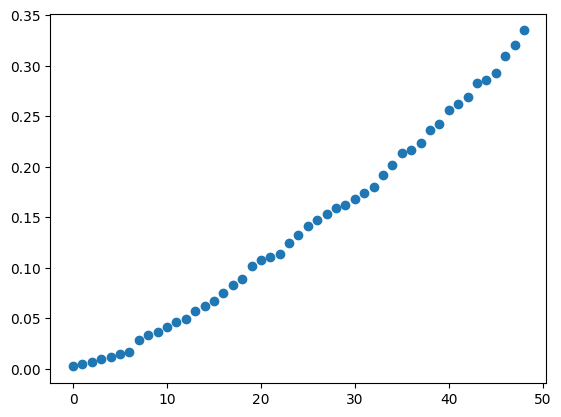

In [109]:
out = iter(out)
y = next(out)
x = np.array([i for i in range(len(y))])
plt.scatter(x=x,y=y)

In [97]:
estimator.predict(X)[0]

-1.043158418291204

In [114]:
estimator.score(X, structured_y)

0.6404231835047672